In [1]:
import keras
#import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, GRU, RNN
from keras.utils import to_categorical, set_random_seed, pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
df = pd.read_csv("df_cleaned.csv")

In [3]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,sentiment,cleaned_text
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,1,"quit,cruel,princ,enjoy,loti,love,back,world,lo..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,1,"hmm,didnt,obsess,one,like,origin,trilogywhil,e..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,0,"oak,disappoint,suren,love,much,cant,pretend,do..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,0,"everi,singl,mention,oak,hoov,jumpscar"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars star fairy_light_skin_tone face_h...,"1,432",0.0,1,"star,star,fairy_light_skin_ton,face_holding_ba..."


In [4]:
import matplotlib.pyplot as plt 

In [5]:
df.drop(columns=['sentiment'], inplace=True)

In [6]:
df = df.dropna(subset=['cleaned_text'])

In [7]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,cleaned_text
0,The Stolen Heir,Emily May,"2,031",310k,4.0,Not quite The Cruel Prince but I enjoyed this ...,"1,206",3.0,"quit,cruel,princ,enjoy,loti,love,back,world,lo..."
1,The Stolen Heir,jessica,"2,563",42.2k,4.0,hmm. i didnt obsess over this one like i did w...,654,0.0,"hmm,didnt,obsess,one,like,origin,trilogywhil,e..."
2,The Stolen Heir,katia,306,526,3.0,"3.5 ★oak was a disappointment, but suren!! i l...","1,233",0.0,"oak,disappoint,suren,love,much,cant,pretend,do..."
3,The Stolen Heir,madeline,111,18,3.0,Every single mention of Oak’s hooves was a jum...,"1,707",4.0,"everi,singl,mention,oak,hoov,jumpscar"
4,The Stolen Heir,Haley pham,81,143k,4.0,4.5 stars star fairy_light_skin_tone face_h...,"1,432",0.0,"star,star,fairy_light_skin_ton,face_holding_ba..."


Number of rows per star rating:
sentiment
2    32784
1     7017
0     6784
Name: count, dtype: int64


/var/folders/66/n0_9mny57ys5rqmlmylz_2880000gn/T/ipykernel_3774/883261720.py:16: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")


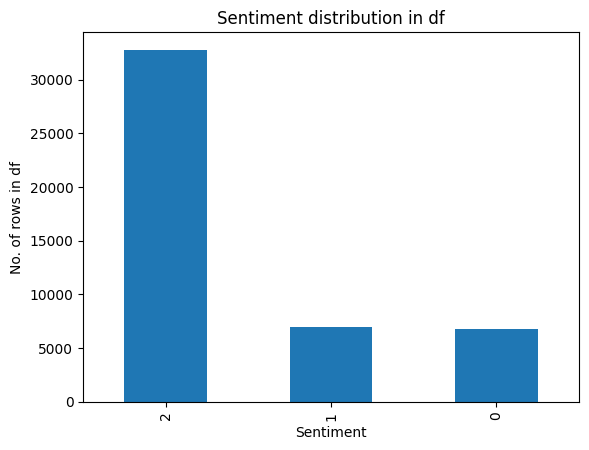

In [8]:
# Function to map stars to sentiment
def map_sentiment(stars_received):
    if stars_received <= 2:
        return 0
    elif stars_received == 3:
        return 1
    else:
        return 2
# Mapping stars to sentiment into three categories
df['sentiment'] = [ map_sentiment(x) for x in df['star_rating']]
print("Number of rows per star rating:")
print(df['sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [9]:
import pandas as pd

# Assuming df is your DataFrame and 'class' is the column representing classes

# Calculate the number of samples needed from each class
samples_per_class = 13000  # Assuming 14000 samples in total

# Sample data points from each class to achieve balance
balanced_data = pd.concat([df[df['sentiment'] == c].sample(samples_per_class, replace=True) for c in df['sentiment'].unique()])

# Reset index of the balanced DataFrame
balanced_data.reset_index(drop=True, inplace=True)

In [10]:
balanced_data.shape

(39000, 10)

In [11]:
balanced_data.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,cleaned_text,sentiment
0,The Maid's Diary,Nina (ninjasbooks),"1,087",628,5.0,"Well, well, well. I might just have found anot...",314,9.0,"well,well,well,might,found,anoth,author,satiat...",2
1,The Twisted Ones,Racheal,"1,015",93,4.0,In my mind I roughly categorize supernatural h...,64,0.0,"mind,roughli,categor,supernatur,horror,two,mai...",2
2,Finna,Tashay,77,4,5.0,I bought my first audiobook so I could hear Na...,3,0.0,"bought,first,audiobook,could,hear,nate,read,wo...",2
3,South to America: A Journey Below the Mason Di...,Lauren,"1,770","2,460",5.0,• SOUTH TO AMERICA: A Journey Below the Mason-...,32,0.0,"south,america,journey,masondixon,understand,so...",2
4,The Paper Daughters of Chinatown,Angela M,"1,331","2,166",4.0,What was I thinking when I picked this up to r...,159,0.0,"think,pick,read,finish,book,brutal,treatment,w...",2


In [12]:
balanced_data.sentiment.value_counts()

sentiment
2    13000
1    13000
0    13000
Name: count, dtype: int64

In [13]:
def convert_to_list(text):
    return text.split(',')
balanced_data["cleaned_text"] = balanced_data["cleaned_text"].apply(convert_to_list)

In [14]:
balanced_data.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,cleaned_text,sentiment
0,The Maid's Diary,Nina (ninjasbooks),"1,087",628,5.0,"Well, well, well. I might just have found anot...",314,9.0,"[well, well, well, might, found, anoth, author...",2
1,The Twisted Ones,Racheal,"1,015",93,4.0,In my mind I roughly categorize supernatural h...,64,0.0,"[mind, roughli, categor, supernatur, horror, t...",2
2,Finna,Tashay,77,4,5.0,I bought my first audiobook so I could hear Na...,3,0.0,"[bought, first, audiobook, could, hear, nate, ...",2
3,South to America: A Journey Below the Mason Di...,Lauren,"1,770","2,460",5.0,• SOUTH TO AMERICA: A Journey Below the Mason-...,32,0.0,"[south, america, journey, masondixon, understa...",2
4,The Paper Daughters of Chinatown,Angela M,"1,331","2,166",4.0,What was I thinking when I picked this up to r...,159,0.0,"[think, pick, read, finish, book, brutal, trea...",2


In [15]:
balanced_data.sentiment.value_counts()

sentiment
2    13000
1    13000
0    13000
Name: count, dtype: int64

## RNN

In [16]:
import keras
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.config.run_functions_eagerly(True)
#from keras.preprocessing.text import Tokenizer

from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, GRU, RNN
from keras.utils import to_categorical, set_random_seed, pad_sequences
from keras.callbacks import EarlyStopping
from keras.optimizers.legacy import Adam

from sklearn.metrics import accuracy_score, confusion_matrix

## Data Processing

In [17]:
df = balanced_data.copy()

In [18]:
df.sentiment.value_counts()

sentiment
2    13000
1    13000
0    13000
Name: count, dtype: int64

In [19]:
# Get the minimum and the maximum length of reviews
max_length = df['cleaned_text'].apply(lambda x: len(x) if isinstance(x, list) else 0).max()
print(f"The maximum length of lists in the column is: {max_length}")
min_length = df['cleaned_text'].apply(lambda x: len(x) if isinstance(x, list) else 0).min()
print(f"The minimum length of lists in the column is: {min_length}")

The maximum length of lists in the column is: 2951
The minimum length of lists in the column is: 1


In [20]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,cleaned_text,sentiment
0,The Maid's Diary,Nina (ninjasbooks),"1,087",628,5.0,"Well, well, well. I might just have found anot...",314,9.0,"[well, well, well, might, found, anoth, author...",2
1,The Twisted Ones,Racheal,"1,015",93,4.0,In my mind I roughly categorize supernatural h...,64,0.0,"[mind, roughli, categor, supernatur, horror, t...",2
2,Finna,Tashay,77,4,5.0,I bought my first audiobook so I could hear Na...,3,0.0,"[bought, first, audiobook, could, hear, nate, ...",2
3,South to America: A Journey Below the Mason Di...,Lauren,"1,770","2,460",5.0,• SOUTH TO AMERICA: A Journey Below the Mason-...,32,0.0,"[south, america, journey, masondixon, understa...",2
4,The Paper Daughters of Chinatown,Angela M,"1,331","2,166",4.0,What was I thinking when I picked this up to r...,159,0.0,"[think, pick, read, finish, book, brutal, trea...",2


In [21]:
# tokenize words to max lenght

# Set the maximum number of words to keep
max_words = 1000

# Create a Tokenizer instance with specified parameters
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token="<OOV>")

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Get the word index mapping
word_index = tokenizer.word_index

# Pad sequences to ensure they have the same length
# max_sequence_length = 100
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')
# 
# # Add the padded sequences as a new column in the DataFrame
df['sequences'] = list(sequences)
# 
# # Print the results
# #print("Word Index:", word_index)
# print("DataFrame with Padded Sequences:")
# print(df.head())

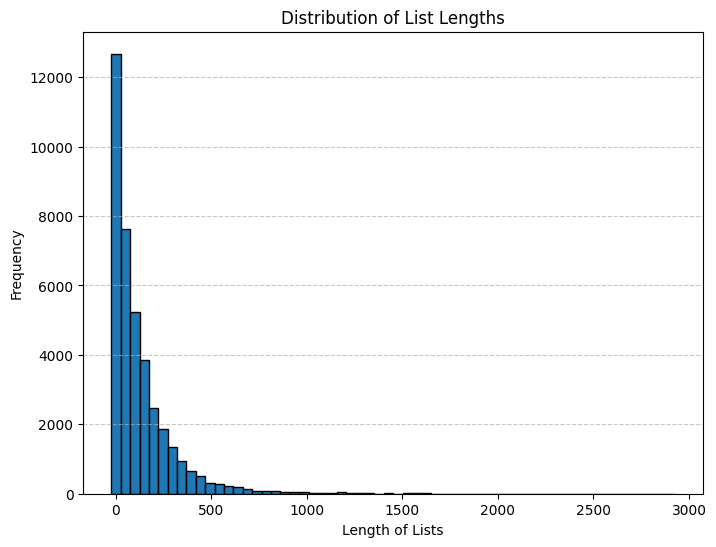

In [37]:
# Calculate lengths of lists
lengths = df.sequences.apply(len)

# Plot the distribution of list lengths
plt.figure(figsize=(8, 6))
plt.hist(lengths, bins=60, align='left', edgecolor='black')
plt.xlabel('Length of Lists')
plt.ylabel('Frequency')
plt.title('Distribution of List Lengths')
#plt.xticks(range(min(lengths), max(lengths) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [38]:
df.head()

,title,reviewer_name,num_reviews,num_followers,star_rating,review_text,num_likes,num_comments,cleaned_text,sentiment,sequences
0,The Maid's Diary,Nina (ninjasbooks),"1,087",628,5.0,"Well, well, well. I might just have found anot...",314,9.0,"[well, well, well, might, found, anoth, author...",2,"[41, 41, 41, 134, 79, 111, 29, 1, 1, 55, 1, 1,..."
1,The Twisted Ones,Racheal,"1,015",93,4.0,In my mind I roughly categorize supernatural h...,64,0.0,"[mind, roughli, categor, supernatur, horror, t...",2,"[219, 1, 1, 1, 328, 54, 141, 381, 1, 328, 1, 1..."
2,Finna,Tashay,77,4,5.0,I bought my first audiobook so I could hear Na...,3,0.0,"[bought, first, audiobook, could, hear, nate, ...",2,"[1, 31, 481, 37, 460, 1, 4, 143, 1, 4, 341, 10..."
3,South to America: A Journey Below the Mason Di...,Lauren,"1,770","2,460",5.0,• SOUTH TO AMERICA: A Journey Below the Mason-...,32,0.0,"[south, america, journey, masondixon, understa...",2,"[1, 570, 478, 1, 123, 867, 916, 1, 1, 142, 315..."
4,The Paper Daughters of Chinatown,Angela M,"1,331","2,166",4.0,What was I thinking when I picked this up to r...,159,0.0,"[think, pick, read, finish, book, brutal, trea...",2,"[16, 247, 4, 252, 2, 1, 1, 87, 1, 1, 142, 1, 1..."


In [39]:
df.sentiment.value_counts()

sentiment
2    13000
1    13000
0    13000
Name: count, dtype: int64

In [40]:
# Split the dataset into training and testing sets
x_train_pd, x_test_pd, y_train_pd, y_test_pd = train_test_split(df['sequences'], df['sentiment'], test_size=0.2, random_state=42)
x_train = x_train_pd.values
x_test = x_test_pd.values
y_train = y_train_pd.values
y_test = y_test_pd.values

In [25]:
y_train_pd.value_counts()

sentiment
1    10412
0    10406
2    10382
Name: count, dtype: int64

In [41]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (31200,)
x_test shape: (7800,)


In [42]:
set_random_seed(0)
max_words = 200
y_train_cat = to_categorical(y_train)

X_train = pad_sequences(x_train, maxlen=max_words)
X_test = pad_sequences(x_test, maxlen=max_words)

print(X_train.shape)

(31200, 200)


### Simple Model

In [43]:
vocabulary_size = 1000
embedding_size=50
model=Sequential()
model.add(InputLayer(input_shape=(max_words,)))
model.add(Embedding(vocabulary_size, embedding_size))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2)) 
model.add(Dense(3, activation='softmax'))
print(model.summary())

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 50)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 200, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 200, 20)        │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 200, 20)        │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,563 (322.51 KB)

 Trainable params: 82,563 (322.51 KB)

 Non-trainable params: 0 (0.00 B)

None


In [44]:
set_random_seed(0)
model.compile(loss='categorical_crossentropy', 
             optimizer='adam', # rmsprop
             metrics=['accuracy'])

batch_size = 256
num_epochs = 50

early = EarlyStopping('val_loss', patience = 15)

history = model.fit(X_train, y_train_cat, validation_split=0.1, batch_size=batch_size, epochs=num_epochs, callbacks=early)

Epoch 1/50


/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


110/110 ━━━━━━━━━━━━━━━━━━━━ 108s 980ms/step - accuracy: 0.3449 - loss: 8248583680.0000 - val_accuracy: 0.4760 - val_loss: 1.0682
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 106s 966ms/step - accuracy: 0.4537 - loss: 174.8391 - val_accuracy: 0.5000 - val_loss: 1.0384
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 107s 970ms/step - accuracy: 0.4694 - loss: 1.0714 - val_accuracy: 0.4827 - val_loss: 1.0482
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 108s 982ms/step - accuracy: 0.4688 - loss: 1.0477 - val_accuracy: 0.4942 - val_loss: 1.0377
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 109s 995ms/step - accuracy: 0.4790 - loss: 1.0409 - val_accuracy: 0.4971 - val_loss: 1.0227
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 107s 978ms/step - accuracy: 0.4799 - loss: 1.0232 - val_accuracy: 0.4939 - val_loss: 1.0123
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 108s 978ms/step - accuracy: 0.4873 - loss: 1.0125 - val_accuracy: 0.4978 - val_loss: 1.0027
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 997ms/step - accuracy: 0.4973 -

In [45]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))


244/244 ━━━━━━━━━━━━━━━━━━━━ 84s 343ms/step
0.33256410256410257
[[2594 2588 2618]
 [   0    0    0]
 [   0    0    0]]


/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


975/975 ━━━━━━━━━━━━━━━━━━━━ 332s 340ms/step
0.33352564102564103


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


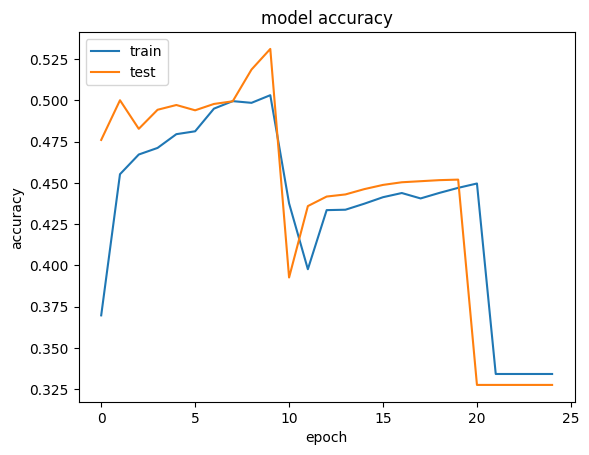

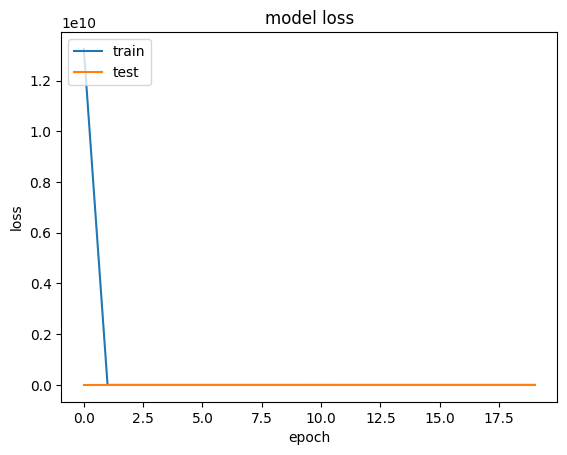

In [46]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model Tunning

In [32]:
def model_builder(hp):
    model = Sequential()
    
    vocabulary_size = 1000
    embedding_size = 50
    max_words = 50  # Assuming you have a max_words variable

    model.add(InputLayer(input_shape=(max_words,)))
    model.add(Embedding(vocabulary_size, embedding_size))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    hp_units_4 = hp.Int('units_4', min_value=10, max_value=100, step=10)

    model.add(LSTM(units=hp_units_1, activation=hp_activation, return_sequences=True))
    # model.add(LSTM(units=hp_units_2, activation=hp_activation, return_sequences=True))
    # model.add(LSTM(units=hp_units_3, activation=hp_activation, return_sequences=True))
    model.add(LSTM(units=hp_units_4, activation=hp_activation))
    
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [33]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x')

Reloading Tuner from dir/x/tuner0.json


In [35]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 26 Complete [00h 05m 27s]
val_accuracy: 0.38985779881477356

Best val_accuracy So Far: 0.5681513547897339
Total elapsed time: 01h 56m 34s


In [46]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'activation': 'tanh',
 'units_1': 20,
 'units_2': 50,
 'units_3': 80,
 'units_4': 40,
 'learning_rate': 0.001,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0002'}

In [38]:
# fit the model based on best params
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2,
                    callbacks=[stop_early])

Epoch 1/50
  2/932 [..............................] - ETA: 56s - loss: 1.0990 - accuracy: 0.2656 

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


932/932 [==============================] - 64s 68ms/step - loss: 0.9943 - accuracy: 0.4722 - val_loss: 0.9275 - val_accuracy: 0.5376
Epoch 2/50
932/932 [==============================] - 65s 70ms/step - loss: 0.9274 - accuracy: 0.5242 - val_loss: 0.9064 - val_accuracy: 0.5468
Epoch 3/50
932/932 [==============================] - 65s 70ms/step - loss: 0.9065 - accuracy: 0.5542 - val_loss: 0.9077 - val_accuracy: 0.5460
Epoch 4/50
932/932 [==============================] - 66s 71ms/step - loss: 0.8881 - accuracy: 0.5640 - val_loss: 0.8993 - val_accuracy: 0.5569
Epoch 5/50
932/932 [==============================] - 66s 70ms/step - loss: 0.8727 - accuracy: 0.5708 - val_loss: 0.9017 - val_accuracy: 0.5553
Epoch 6/50
932/932 [==============================] - 67s 72ms/step - loss: 0.8637 - accuracy: 0.5797 - val_loss: 0.9032 - val_accuracy: 0.5555
Epoch 7/50
932/932 [==============================] - 66s 71ms/step - loss: 0.8538 - accuracy: 0.5833 - val_loss: 0.9105 - val_accuracy: 0.5566


In [41]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))

# Changing max_words for longer sequences and vocabulary size for more different words
# That makes the network run for much much longer

  5/292 [..............................] - ETA: 7s

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


292/292 [==============================] - 8s 26ms/step
0.556509606096383
[[1566  531  324]
 [ 799 1196  862]
 [ 402 1214 2423]]


In [43]:
y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))

   5/1165 [..............................] - ETA: 30s

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1165/1165 [==============================] - 30s 26ms/step
0.6033594504668884


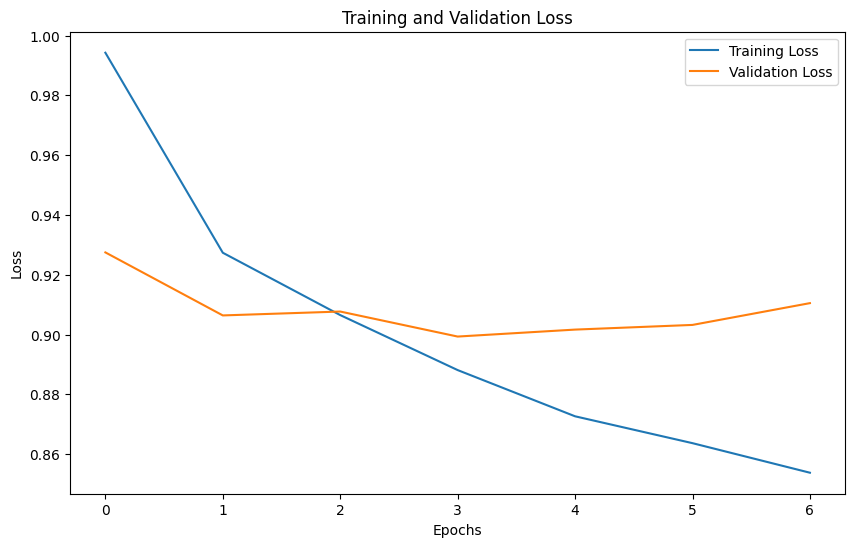

In [39]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


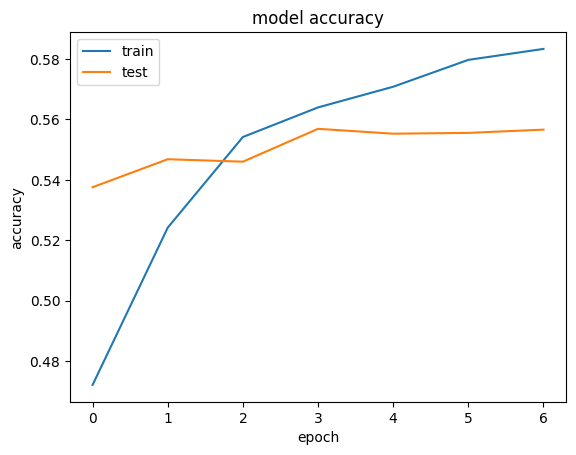

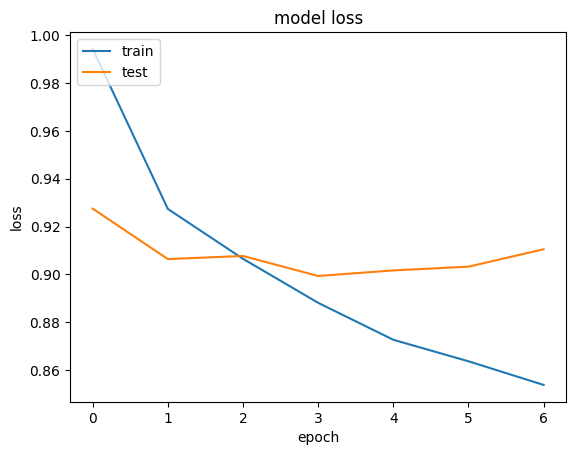

In [40]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Second Tunning

In [51]:
def model_builder(hp):
    model = Sequential()
    
    vocabulary_size = 1000
    embedding_size = 50
    max_words = 50  # Assuming you have a max_words variable

    model.add(InputLayer(input_shape=(max_words,)))
    model.add(Embedding(vocabulary_size, embedding_size))

    hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    #hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    hp_units_4 = hp.Int('units_4', min_value=10, max_value=100, step=10)

    model.add(LSTM(units=hp_units_1, activation=hp_activation, return_sequences=True))
    model.add(LSTM(units=hp_units_2, activation=hp_activation, return_sequences=True))
    # model.add(LSTM(units=hp_units_3, activation=hp_activation, return_sequences=True))
    model.add(LSTM(units=hp_units_4, activation=hp_activation))
    
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.2)) 
    model.add(Dense(3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [58]:
import keras_tuner as kt

second_tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='dir',
                     project_name='x_2')

In [59]:
stop_early = EarlyStopping(monitor='val_loss', patience=3)
second_tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 35m 43s]
val_accuracy: 0.5367587804794312

Best val_accuracy So Far: 0.5639925003051758
Total elapsed time: 12h 50m 01s


In [60]:
best_hps_two = second_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps_two.values

{'activation': 'tanh',
 'units_1': 60,
 'units_2': 100,
 'units_4': 100,
 'learning_rate': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

In [61]:
#best_hps.values
# fit the model based on best params
model = second_tuner.hypermodel.build(best_hps_two)
history_two = model.fit(X_train, y_train, epochs=50, validation_split=0.2,
                    callbacks=[stop_early])

Epoch 1/50
  1/932 [..............................] - ETA: 2:37 - loss: 1.0986 - accuracy: 0.2188

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


932/932 [==============================] - 138s 148ms/step - loss: 0.9855 - accuracy: 0.5031 - val_loss: 0.9264 - val_accuracy: 0.5397
Epoch 2/50
932/932 [==============================] - 138s 148ms/step - loss: 0.9214 - accuracy: 0.5439 - val_loss: 0.9160 - val_accuracy: 0.5471
Epoch 3/50
932/932 [==============================] - 136s 146ms/step - loss: 0.9023 - accuracy: 0.5554 - val_loss: 0.9080 - val_accuracy: 0.5476
Epoch 4/50
932/932 [==============================] - 138s 148ms/step - loss: 0.8834 - accuracy: 0.5682 - val_loss: 0.9085 - val_accuracy: 0.5534
Epoch 5/50
932/932 [==============================] - 132s 142ms/step - loss: 0.8707 - accuracy: 0.5717 - val_loss: 0.9015 - val_accuracy: 0.5559
Epoch 6/50
932/932 [==============================] - 131s 141ms/step - loss: 0.8623 - accuracy: 0.5778 - val_loss: 0.9059 - val_accuracy: 0.5559
Epoch 7/50
932/932 [==============================] - 131s 141ms/step - loss: 0.8477 - accuracy: 0.5864 - val_loss: 0.9186 - val_accura

In [62]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))

y_train_pred = np.argmax(model.predict(X_train), axis=1)
print(accuracy_score(y_train_pred, y_train))

  2/292 [..............................] - ETA: 15s

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


292/292 [==============================] - 15s 53ms/step
0.5609101642159493
[[1735  666  461]
 [ 619 1034  691]
 [ 413 1241 2457]]
   3/1165 [..............................] - ETA: 1:01

/Users/blankajarmoszko/PycharmProjects/Selenium_trial/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1165/1165 [==============================] - 62s 53ms/step
0.6170709455833423


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


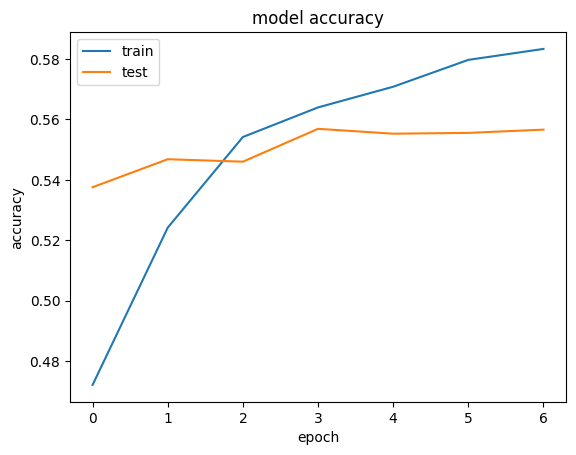

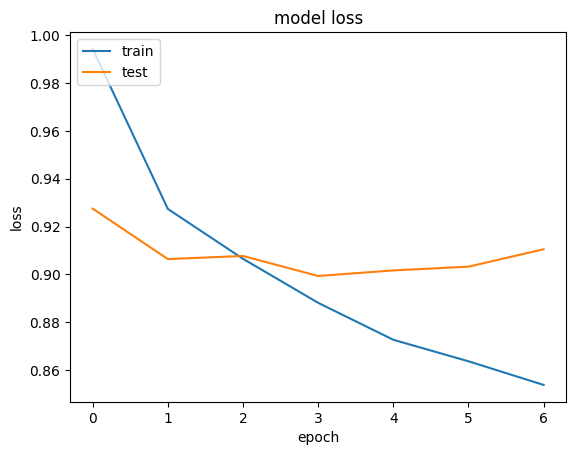

In [63]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Dropout
# BERT models
# true classes?
# use clustering for sentiment analysis, look at star distribution
# two class classification
# 
# https://medium.com/@chyun55555/unsupervised-sentiment-analyis-with-sentiwordnet-and-vader-in-python-a519660198be

In [ ]:
# pre trained models for transfer learning